# AutTextification competition

## Part 0: Exploratory Data Analysis

In [2]:
!pip install transformers
!pip install datasets
!pip install shap

In [3]:
from nltk.corpus                     import stopwords
from datasets                        import Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm                            import tqdm
from sklearn.metrics                 import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection         import train_test_split
from transformers                    import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
import tensorflow                    as tf
import matplotlib.pyplot             as plt
import pandas                        as pd
import numpy                         as np
import scipy                         as sp
import torch
import shap
import spacy
import nltk
import glob

plt.style.use('ggplot')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
EN_TRAIN_DATA = '/content/drive/MyDrive/Personal/AuTextification/subtask_1/en'
ES_TRAIN_DATA = '/content/drive/MyDrive/Personal/AuTextification/subtask_1/es'

In [5]:
train_df_en = pd.read_csv('/kaggle/input/autextification/train_en.tsv', sep='\t')
train_df_en['lang'] = 'en'

train_df_es = pd.read_csv('/kaggle/input/autextification/train_es.tsv', sep='\t')
train_df_es['lang'] = 'es'

train_df = pd.concat([train_df_en, train_df_es])
train_df.reset_index(drop=True, inplace=True)
train_df['label'] = train_df['label'].apply(lambda x: 1 if x == 'generated' else 0)

## Train test split

In [7]:
train_df, test_df = train_test_split(train_df[['text', 'label']], test_size=0.2, random_state=42)

In [8]:
train_df = Dataset.from_pandas(train_df)
test_df  = Dataset.from_pandas(test_df)

In [9]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
device    = "cuda" if torch.cuda.is_available() else "cpu"
# prepare los datos para el modelo
def prepare_data(data):
    text = data['text']
    label = data['label']
    tokenized_text = tokenizer(text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    
    # Recorrer cada diccionario en la lista y aplicar 'to()' a cada tensor dentro del diccionario
    for key in tokenized_text:
        tokenized_text[key] = tokenized_text[key].to(device)
        
    return {
        'input_ids': tokenized_text['input_ids'].tolist(),
        'attention_mask': tokenized_text['attention_mask'].tolist(),
        'label': label,
    }

train_df = train_df.map(prepare_data, batched=True)
test_df = test_df.map(prepare_data, batched=True)

  0%|          | 0/53 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

## Load model

In [10]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-cased').to(device)

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = 'epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy = 'epoch', # establecer la estrategia de guardado en 'epoch'
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    fp16=True
)


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

## Fit model

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_df,
    eval_dataset=test_df,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(axis=-1)),
        'precision': precision_score(p.label_ids, p.predictions.argmax(axis=-1)),
        'recall': recall_score(p.label_ids, p.predictions.argmax(axis=-1)),
        'f1': f1_score(p.label_ids, p.predictions.argmax(axis=-1))
    },
)

__Cased version__

In [12]:
trainer.train()

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.241600,0.236673,0.906387,0.880825,0.941159,0.909993
2,0.139900,0.250389,0.928766,0.918863,0.941460,0.930025
3,0.064400,0.455276,0.914353,0.871805,0.972692,0.919489


TrainOutput(global_step=9888, training_loss=0.1750057600076916, metrics={'train_runtime': 9515.6834, 'train_samples_per_second': 16.623, 'train_steps_per_second': 1.039, 'total_flos': 4.1617591181568e+16, 'train_loss': 0.1750057600076916, 'epoch': 3.0})

In [16]:
best_model_path = "/kaggle/working/bert_cased_best_model.pth"
torch.save(trainer.model.state_dict(), best_model_path)

In [17]:
with torch.no_grad():
    predictions, labels, metrics = trainer.predict(test_df, metric_key_prefix="predict")
    predictions = np.argmax(predictions, axis=1)

## Confussion Matrix

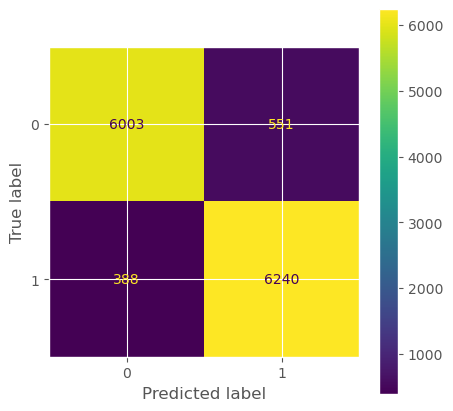

In [18]:
fig, ax = plt.subplots(figsize=(5,5))
cm = confusion_matrix(test_df['label'], predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

disp.plot(ax=ax)
plt.show()

## Shap values

In [19]:
# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x]).cuda()
    outputs = trainer.model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews
shap_values = explainer(test_df[:50], fixed_context=1)

Partition explainer: 51it [02:25,  3.04s/it]                      


In [20]:
# plot the first sentence's explanation
shap.plots.text(shap_values[48])

In [22]:
# plot the first sentence's explanation
shap.plots.text(shap_values[49])

In [23]:
# plot the first sentence's explanation
shap.plots.text(shap_values[45])